In [ ]:
%matplotlib inline
%autosave 0
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dtrace import rpath
from dtrace.TargetHit import TargetHit
from dtrace.Associations import Association

### Import data-sets and associations

In [ ]:
assoc = Association(dtype="ic50", load_associations=True)
lmm_combined = pd.concat(
    [
        assoc.lmm_drug_crispr.set_index(
            ["DRUG_ID", "DRUG_NAME", "VERSION", "GeneSymbol"]
        ).add_prefix("CRISPR_"),
        assoc.lmm_drug_gexp.set_index(
            ["DRUG_ID", "DRUG_NAME", "VERSION", "GeneSymbol"]
        ).add_prefix("GExp_"),
    ],
    axis=1,
    sort=False,
).dropna()

## MCL1 inhibitors associations

Analysis of the significant associations between multiple MCL1 inhibitors (MCL1i) and MCL1 and MARCH5
gene-essentiality.

In [6]:
hit = TargetHit(
    "MCL1",
    lmm_dcrispr=assoc.lmm_drug_crispr,
    lmm_dgexp=assoc.lmm_drug_gexp,
    lmm_comb=lmm_combined,
)

### Top associations with MCL1i

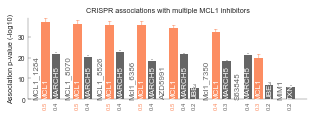

In [11]:
hit.top_associations_barplot()
plt.ylabel("Association p-value (-log10)")
plt.title("CRISPR associations with multiple MCL1 inhibitors")
plt.gcf().set_size_inches(5, 1.5)
plt.savefig(f"{rpath}/hit_topbarplot.pdf", bbox_inches="tight", transparent=True)

### Correlation plots of multiple MCL1i and MCL1/MARCH5

/Users/eg14/anaconda3/envs/crispy/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


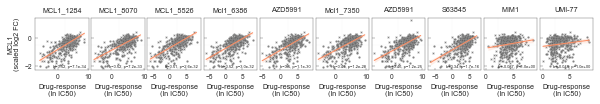

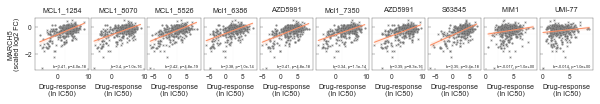

In [12]:
order = [
    tuple(d)
    for d in assoc.lmm_drug_crispr.query(f"(DRUG_TARGETS == 'MCL1') & (GeneSymbol == 'MCL1')")[
        hit.dinfo
    ].values
]
for g in ["MCL1", "MARCH5"]:
    hit.plot_target_drugs_corr(assoc, g, order=order)

    plt.savefig(
        f"{rpath}/hit_target_drugs_corr_{g}.pdf", bbox_inches="tight", transparent=True
    )

### BCL inhbitors association effects

Associations effect sizes (betas) of inhibitors of BCL family members (MCL1, BCL2L1/BCL-XL and BCL2) drug-response
with gene-essentiality and gene-expression.

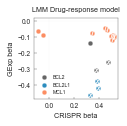

In [13]:
hit.plot_drug_crispr_gexp(["MCL1", "BCL2", "BCL2L1"])
plt.gcf().set_size_inches(1.5, 1.5)
plt.savefig(f"{rpath}/hit_BCLi_crispr~gexp.pdf", bbox_inches="tight", transparent=True)

In [ ]:
# -
features = [
    "MARCH5",
    "MCL1",
    "BCL2",
    "BCL2L1",
    "BCL2L11",
    "PMAIP1",
    "BAX",
    "BAK1",
    "BBC3",
    "BID",
    "BIK",
    "BAD",
]
drug_lms = hit.predict_drugresponse(data, features)

In [ ]:
hit.predict_r2_barplot(drug_lms)
plt.gcf().set_size_inches(1.5, 2.5)
plt.savefig(f"reports/hit_rsqaured_barplot.pdf", bbox_inches="tight", transparent=True)
plt.close("all")

In [ ]:
hit.predict_feature_plot(drug_lms)
plt.gcf().set_size_inches(1.5, 3)
plt.savefig(
    f"reports/hit_features_stripplot.pdf", bbox_inches="tight", transparent=True
)
plt.close("all")

In [ ]:
# - CRISPR gene pair corr
for gene_x, gene_y in [("MARCH5", "MCL1")]:
    plot_df = pd.concat(
        [
            data.crispr.loc[gene_x].rename(gene_x),
            data.crispr.loc[gene_y].rename(gene_y),
            data.crispr_obj.institute.rename("Institute"),
        ],
        axis=1,
        sort=False,
    ).dropna()

    g = DTracePlot().plot_corrplot(gene_x, gene_y, "Institute", plot_df, add_hline=True)

    g.set_axis_labels(f"{gene_x} (scaled log2 FC)", f"{gene_y} (scaled log2 FC)")

    plt.gcf().set_size_inches(1.5, 1.5)
    plt.savefig(
        f"reports/hit_scatter_{gene_x}_{gene_y}.pdf",
        bbox_inches="tight",
        transparent=True,
    )
    plt.close("all")

In [ ]:
# -
ctypes = ["Breast Carcinoma", "Colorectal Carcinoma", "Acute Myeloid Leukemia"]
genes = ["MCL1", "MARCH5"]
order = ["None", "MARCH5", "MCL1", "MCL1 + MARCH5"]
hue_order = [
    "Other",
    "Breast Carcinoma",
    "Colorectal Carcinoma",
    "Acute Myeloid Leukemia",
]

In [ ]:
#
hit.drugresponse_boxplots(
    data, ctypes=ctypes, hue_order=hue_order, order=order, genes=genes
)
plt.savefig(
    f"reports/hit_drugresponse_boxplot.pdf", bbox_inches="tight", transparent=True
)
plt.close("all")

In [ ]:
#
# drug = (1956, 'MCL1_1284', 'RS')
for drug in [(1956, "MCL1_1284", "RS"), (2235, "AZD5991", "RS")]:
    plot_df = pd.concat(
        [
            data.drespo.loc[drug].rename("drug"),
            hit.discretise_essentiality(genes).rename("essentiality"),
            data.samplesheet.samplesheet.loc[data.samples, "cancer_type"],
        ],
        axis=1,
        sort=False,
    )
    plot_df["ctype"] = plot_df["cancer_type"].apply(
        lambda v: v if v in ctypes else "Other"
    )

    ctypes = ["Colorectal Carcinoma", "Breast Carcinoma"]

    fig, axs = plt.subplots(1, len(ctypes), sharey="all", sharex="all")

    for i, tissue in enumerate(ctypes):
        df = plot_df.query(f"ctype == '{tissue}'")

        g = DTracePlot().plot_multiple(
            "drug", "essentiality", df, n_offset=1, n_fontsize=5, ax=axs[i]
        )

        sns.despine(ax=axs[i])

        dmax = np.log(data.drespo_obj.maxconcentration[drug])
        axs[i].axvline(
            dmax, linewidth=0.3, color=DTracePlot.PAL_DTRACE[2], ls=":", zorder=0
        )

        daml = plot_df.query("cancer_type == 'Acute Myeloid Leukemia'")["drug"].mean()
        axs[i].axvline(
            daml, linewidth=0.3, color=DTracePlot.PAL_DTRACE[0], ls=":", zorder=0
        )

        axs[i].set_xlabel(f"{drug[1]} (ln IC50, {drug[2]})")
        axs[i].set_ylabel("")

        axs[i].set_title(tissue)

    plt.gcf().set_size_inches(2 * len(ctypes), 0.75)
    plt.savefig(
        f"reports/hit_drugresponse_boxplot_tissue_{drug[1]}.pdf",
        bbox_inches="tight",
        transparent=True,
    )
    plt.close("all")

In [ ]:
# - MCL1 amplification
d, c = ("MCL1_1284", "MCL1")

In [ ]:
assoc = lmm_drug[(lmm_drug["DRUG_NAME"] == d) & (lmm_drug["GeneSymbol"] == c)].iloc[0]

In [ ]:
drug = tuple(assoc[data.drespo_obj.DRUG_COLUMNS])

In [ ]:
dmax = np.log(data.drespo_obj.maxconcentration[drug])

In [ ]:
plot_df = pd.concat(
    [
        data.drespo.loc[drug].rename("drug"),
        data.crispr.loc[c].rename("crispr"),
        data.cn.loc["MCL1"].rename("cn"),
        data.crispr_obj.institute.rename("Institute"),
        data.samplesheet.samplesheet["ploidy"],
    ],
    axis=1,
    sort=False,
).dropna()

In [ ]:
plot_df = plot_df.assign(
    amp=[
        1 if ((p <= 2.7) and (c >= 5)) or ((p > 2.7) and (c >= 9)) else 0
        for p, c in plot_df[["ploidy", "cn"]].values
    ]
)

In [ ]:
grid = DTracePlot.plot_corrplot_discrete("crispr", "drug", "amp", "Institute", plot_df)

In [ ]:
grid.ax_joint.axhline(
    y=dmax, linewidth=0.3, color=DTracePlot.PAL_DTRACE[2], ls=":", zorder=0
)

In [ ]:
grid.set_axis_labels(f"{c} (scaled log2 FC)", f"{d} (ln IC50)")

In [ ]:
plt.suptitle("MCL1 amplification", y=1.05, fontsize=8)

In [ ]:
plt.gcf().set_size_inches(1.5, 1.5)
plt.savefig(
    f"reports/hit_scatter_{d}_{c}_amp.pdf", bbox_inches="tight", transparent=True
)
plt.close("all")